# Analyze woltka functional profiles

In [29]:
import pandas as pd
import numpy as np
from glob import glob
import os
from biom.util import biom_open
from biom import Table, load_table
import qiime2 as q2
from skbio.diversity import beta
from skbio.stats.distance import permanova
from skbio.stats.distance import mantel
from skbio import DistanceMatrix
from qiime2.plugins.songbird.actions import multinomial 
from qiime2.plugins.songbird.actions import summarize_paired 


from scipy.stats import sem
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from math import log

import matplotlib.pyplot as plt
import plotnine as pn

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix

#biom shortcuts
o="observation"
s="sample"

## Import and format profiles

In [4]:
def save_biom(biom_filename, biom_table,author='default'):
    with biom_open(biom_filename, 'w') as f:  
            biom_table.to_hdf5(f, author)
    print("Saved to " + biom_filename)

#Import if already formatted, else: format
profile_name = "merged_functional_profile.tsv"
bt_name = "merged_functional_profile.biom"

if os.path.exists(bt_name):
    print("Loading previously saved biom table: {}".format(bt_name))
    #df = pd.read_csv(profile_name, sep='\t', index_col=0)
    bt = load_table(bt_name)
else:
    print("Making new biom table.")
    profile_list = glob("profiles/*.txt")
    out_list = []
    for p in profile_list:
        name = p.split("/")[-1].replace(".St_fprofile.txt","")
        temp_df = pd.read_csv(p, sep='\t', index_col=0)
        temp_df.columns = [name]
        out_list.append(temp_df[name])
    df = pd.DataFrame(out_list)
    df = df.fillna(0)
    df.index.name="sample_name"
    #Tanspose
    df = df.transpose()
    #Save df
    df.to_csv(profile_name, sep='\t', index_label="sample_name")
    
    #Convert to biom
    bt = Table.from_tsv(open(profile_name,'r'), None, None, lambda x:x)
    #Save biom
    save_biom(bt_name, bt)

Loading previously saved biom table: merged_functional_profile.biom


### Import metadata

In [5]:
md=pd.read_csv("/projects/cmi_proj/seed_grants/T1D_JaneKim/11129_20200129-223118.txt", sep='\t', index_col=0)

#Filter metadata to only sampels in df and put in same order
bt_samples = set(bt.ids("sample"))
md = md.query('index.str.contains(".St")').copy()
md.index = [x.replace(".St","") for x in md.index]
md = md.query('index in @bt_samples').copy()
md = md.reindex(bt.ids("sample"))
md.index.name="sample_name"
qza_md = q2.Metadata(md)

## Filter low abundance gene calls  
600k features(genes) in biom table  
min 100 reduces to 100k features

In [ ]:
bt_ss = bt.filter( ids_to_keep = bt.ids(o)[bt.sum(o) > 99], axis=o, inplace=False)

## Calculate diversity

In [ ]:
import qiime2 as q2
from qiime2.plugins.deicode.actions import rpca

#Import to qiime
qza = q2.Artifact.import_data('FeatureTable[Frequency]', bt_ss)
qza.save("merged_functional_profile_100.qza")


In [2]:
from qiime2.plugins.diversity.actions import beta

In [4]:
?beta

## Rpca runs out of memory

In [7]:
%%script bash
echo '
#!/bin/bash -l
#PBS -m ae
#PBS -M swandro@ucsd.edu
#PBS -S /bin/bash
#PBS -e /projects/cmi_proj/seed_grants/T1D_JaneKim/logs
#PBS -o /projects/cmi_proj/seed_grants/T1D_JaneKim/logs
#PBS -l walltime=4:00:00
#PBS -l nodes=1:ppn=32
#PBS -l mem=256gb
#PBS -N rpca_t1d_func

source ~/.bash_profile
conda activate qiime2-2020.2

cd /projects/cmi_proj/seed_grants/T1D_JaneKim/shogun_function

qiime deicode rpca \
--i-table merged_functional_profile_100.qza \
--o-biplot biplot_functional_profile_100.qza \
--o-distance-matrix DM_functional_profile_100.qza

' | qsub

1313999.barnacle.ucsd.edu


## Bray-curtis

In [7]:
%%script bash
echo '
#!/bin/bash -l
#PBS -m ae
#PBS -M swandro@ucsd.edu
#PBS -S /bin/bash
#PBS -e /projects/cmi_proj/seed_grants/T1D_JaneKim/logs
#PBS -o /projects/cmi_proj/seed_grants/T1D_JaneKim/logs
#PBS -l walltime=12:00:00
#PBS -l nodes=1:ppn=16
#PBS -l mem=128gb
#PBS -N bc_t1d_func

source ~/.bash_profile
conda activate qiime2-2020.2

cd /projects/cmi_proj/seed_grants/T1D_JaneKim/shogun_function

qiime diversity beta \
--i-table merged_functional_profile_100.qza \
--p-metric "braycurtis" \
--o-distance-matrix DM_functional_profile_100.qza

' | qsub

1315298.barnacle.ucsd.edu


## Import BC DM

In [10]:
!ls

analyze_woltka_profile.ipynb	   merged_functional_profile.tsv
DM_functional_profile_100.qza	   profiles
merged_functional_profile_100.qza  prof_test
merged_functional_profile.biom	   woltka_functional_profiling.ipynb


In [3]:
dm_qza = q2.Artifact.load('DM_functional_profile_100.qza')
dm = dm_qza.view(DistanceMatrix)

#Sort md
md = md.reindex(dm.ids)
assert all([a==b for a,b in zip(dm.ids,md.index)]) , "Indices not in correct order."

NameError: name 'md' is not defined

In [5]:
perm_t1d = permanova(distance_matrix=dm, 
                     grouping=md.analysis_t1d, 
                     permutations=5000)

In [6]:
perm_t1d

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     112
number of groups                  2
test statistic              1.14523
p-value                    0.240952
number of permutations         5000
Name: PERMANOVA results, dtype: object

# Get higher level classifications of Uniref
Because woltka doesn't work right now

## kegg KO

In [10]:
!ls /projects/wol/20170307/release/annotation/kegg

ko.map.xz  readme.txt


In [9]:
import json
kegg_json_file = "databases/ko00001.json"
with open(kegg_json_file) as openfile:
    json_parsed = json.loads(openfile.read())
json_parsed

{'name': 'ko00001',
 'children': [{'name': '09100 Metabolism',
   'children': [{'name': '09101 Carbohydrate metabolism',
     'children': [{'name': '00010 Glycolysis / Gluconeogenesis [PATH:ko00010]',
       'children': [{'name': 'K00844  HK; hexokinase [EC:2.7.1.1]'},
        {'name': 'K12407  GCK; glucokinase [EC:2.7.1.2]'},
        {'name': 'K00845  glk; glucokinase [EC:2.7.1.2]'},
        {'name': 'K01810  GPI, pgi; glucose-6-phosphate isomerase [EC:5.3.1.9]'},
        {'name': 'K06859  pgi1; glucose-6-phosphate isomerase, archaeal [EC:5.3.1.9]'},
        {'name': 'K13810  tal-pgi; transaldolase / glucose-6-phosphate isomerase [EC:2.2.1.2 5.3.1.9]'},
        {'name': 'K15916  pgi-pmi; glucose/mannose-6-phosphate isomerase [EC:5.3.1.9 5.3.1.8]'},
        {'name': 'K00850  pfkA, PFK; 6-phosphofructokinase 1 [EC:2.7.1.11]'},
        {'name': 'K16370  pfkB; 6-phosphofructokinase 2 [EC:2.7.1.11]'},
        {'name': 'K21071  pfk, pfp; ATP-dependent phosphofructokinase / diphosphate-depen

In [10]:
def extract_values(obj, key):
    """Pull all values of specified key from nested JSON."""
    arr = []

    def extract(obj, arr, key):
        """Recursively search for values of key in JSON tree."""
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr, key)
                elif k == key:
                    arr.append(v)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
        return arr

    results = extract(obj, arr, key)
    return results

In [11]:
json_names = extract_values(json_parsed,"name")
kegg_ids = {x.split()[0]:' '.join(x.split()[1:]) for x in json_names if x[0]=="K"}

In [12]:
import lzma
uniref_kegg_dict = {}
with lzma.open("/projects/wol/20170307/release/annotation/kegg/ko.map.xz", mode="rb") as openfile:
    for line in openfile:
        linesplit = line.decode('UTF-8').split()
        uniref_kegg_dict[linesplit[0]] = linesplit[1:]


In [13]:
kegg_dict = {}
features_to_keep=set()
y ,n = 0,0
for uniref_id in bt.ids(o):
    try:
        kegg_dict[uniref_id] =  {"kegg":uniref_kegg_dict[uniref_id][0]}
        features_to_keep.add(uniref_id)
        y+=1
    except KeyError:
        n+=1
print("Uniref hits in Kegg: %s" % y)
print("Uniref hits NOT in Kegg: %s" % n)

Uniref hits in Kegg: 48152
Uniref hits NOT in Kegg: 597444


In [14]:
#Filter to only uniref with kegg
kegg_bt = bt.copy()
print("Uniref features: %s" % kegg_bt.shape[0] )
kegg_bt.add_metadata(kegg_dict, axis=o)
kegg_bt.filter(features_to_keep, axis=o)
print("Uniref features with kegg: %s" % kegg_bt.shape[0] )

#Collapse by kegg
bin_f = lambda id_, x: x['kegg']
kegg_bt = kegg_bt.collapse(bin_f, norm=False, axis="observation")
print("Collapsed kegg features: %s" % kegg_bt.shape[0] )

Uniref features: 645596
Uniref features with kegg: 48152
Collapsed kegg features: 5162


## Kegg permanova

In [12]:
from skbio.diversity import beta_diversity

In [13]:
x= pd.DataFrame(kegg_bt.to_dataframe()).transpose()
bc = beta_diversity(metric="braycurtis", counts=x.values, ids=kegg_bt.ids(s))
perm_kegg_t1d = permanova(distance_matrix=bc, 
                     grouping=md.analysis_t1d, 
                     permutations=5000)
perm_kegg_t1d

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     112
number of groups                  2
test statistic              1.71347
p-value                    0.108378
number of permutations         5000
Name: PERMANOVA results, dtype: object

In [18]:
perm_kegg_weight = permanova(distance_matrix=bc, 
                     grouping=md.analysis_weight_group, 
                     permutations=5000)
perm_kegg_weight

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     112
number of groups                  2
test statistic              1.16002
p-value                    0.262148
number of permutations         5000
Name: PERMANOVA results, dtype: object

In [24]:
pd.DataFrame([perm_kegg_t1d,perm_kegg_weight], index=["T1D","Weight group"])

method name test statistic name  sample size  number of groups  \
T1D            PERMANOVA            pseudo-F          112                 2   
Weight group   PERMANOVA            pseudo-F          112                 2   

              test statistic   p-value  number of permutations  
T1D                  1.71347  0.109778                    5000  
Weight group         1.16002  0.262148                    5000

# Differential abundance

In [4]:
#Set up dictionaries
factor_dict = {"t1d":"analysis_t1d", "weight":"analysis_weight_group", "null":"1" }
songbird_dict = {"t1d":{},"weight":{},"null":{}}

def b2q(bt):
    return(q2.Artifact.import_data('FeatureTable[Frequency]',bt))

#Run/Import Songbird
folder = "kegg/songbird/"
for factor in ["t1d","weight","null"]:
    folder = "songbird/kegg/" + factor
    if not os.path.exists(folder):
        ! mkdir -p $folder
        #Calculate Songbird
        (temp_differentials,
         temp_regression_stats,
         temp_regression_biplot) = multinomial(table=b2q(kegg_bt),
                                               metadata=qza_md,
                                               formula=factor_dict[factor])
        #Add outputs to master dictionary
        songbird_dict[factor]["differentials"] = temp_differentials
        songbird_dict[factor]["regression_stats"] = temp_regression_stats
        songbird_dict[factor]["regression_biplot"] = temp_regression_biplot
        #Save outputs
        temp_differentials.save(folder + "/differentials.qza")
        temp_regression_stats.save(folder + "/regression_stats.qza")
        temp_regression_biplot.save(folder + "/regression_biplot.qza")
    else:
        songbird_dict[factor]["differentials"] = q2.Artifact.load(folder + "/differentials.qza")
        songbird_dict[factor]["regression_stats"] = q2.Artifact.load(folder + "/regression_stats.qza")
        songbird_dict[factor]["regression_biplot"] = q2.Artifact.load(folder + "/regression_biplot.qza")

### Evaluate model fit

t1d
weight


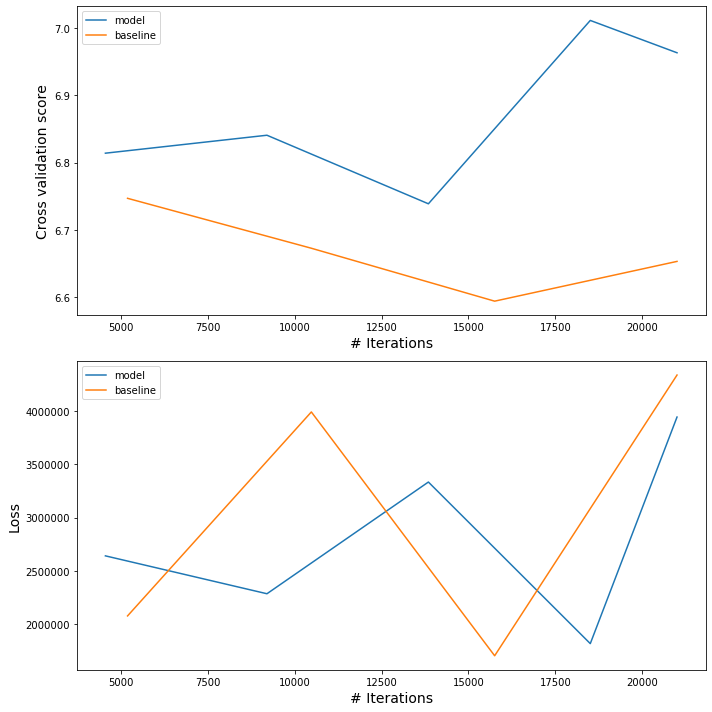

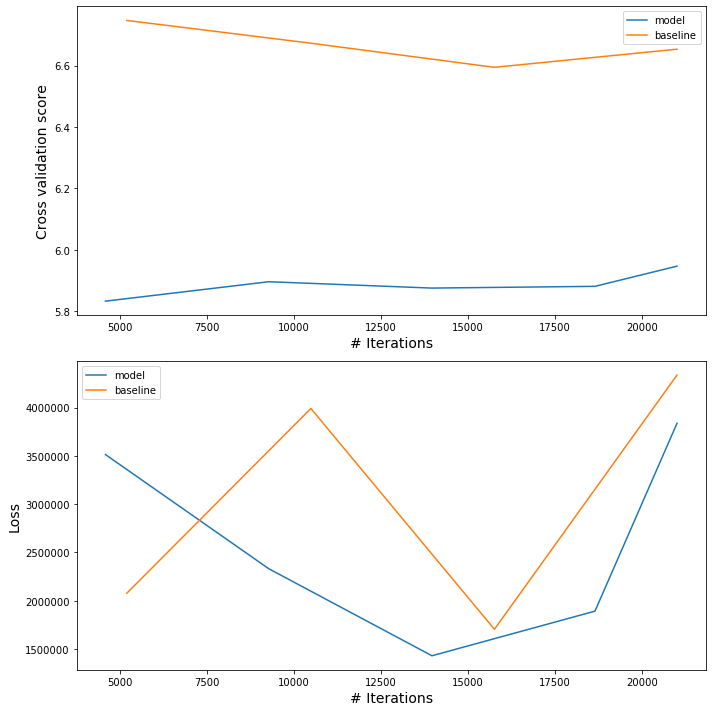

In [17]:
tensor_dict = {}
for factor in ["t1d","weight"]:
    folder = "songbird/kegg/" + factor
    print(factor)
    tensor_dict[factor] = summarize_paired(regression_stats = songbird_dict[factor]["regression_stats"],
                                                       baseline_stats = songbird_dict["null"]["regression_stats"]).visualization
    #Save output
    tensor_dict[factor].save(folder + "/model_fit_stats.qzv")

## Get top KOs from songbird differentials

In [15]:
differential_dict = {}

for factor in ["t1d","weight"]:
    differentials_df = songbird_dict[factor]["differentials"].view(pd.DataFrame)
    #Add metabolite metadata
    #differentials_df = differentials_df.merge(md, right_index=True, left_index=True)
    sort_col = differentials_df.columns[1]
    differentials_df = differentials_df.sort_values(sort_col)
    differentials_df["kegg"] = [kegg_ids[x] if x in kegg_ids.keys() else '' for x in differentials_df.index]
    differential_dict[factor] = differentials_df
    


In [17]:
#Save differential dicts
for factor,df in differential_dict.items():
    folder = "songbird/kegg/" + factor
    df.to_csv(folder + "/kegg_{}_songbird_differentials.tsv".format(factor), sep='\t')

In [118]:
def top_bottom(df, n=10):
    #Function for viewing a table
    return df.head(n).append(df.tail(n)).style.bar(subset=df.columns[1], align='mid', color=['#00BFC4','#F8766D'])

In [124]:
top_bottom(differential_dict["weight"], n=10)

In [125]:
top_bottom(differential_dict["t1d"], n=10)

## Mantel correlation genes to 16S

In [116]:
#Import DM from 16S and shogun

DM_16S_dict = {name:q2.Artifact.load("/home/swandro/T1D_v2/16S_analysis/Beta/" + x).view(DistanceMatrix) for name,x in zip(["uw_unifrac","w_unifrac","deicode"],
                                                                                                                           ["unweighted_unifrac.qza","weighted_unifrac.qza","deicode_dm.qza"])}

In [111]:
mantel_dict = {}

for name,dm2 in DM_16S_dict.items():
    samples_keep = set(dm.ids) & set(dm2.ids)
    dm1_filter = dm.filter(samples_keep)
    dm2_filter = dm2.filter(samples_keep)
    m = mantel(x=dm1_filter, y=dm2_filter, method='pearson')
    mantel_dict[name] = m

In [112]:
mantel_dict

{'uw_unifrac': (0.21828370747881526, 0.002, 104),
 'w_uinifrac': (0.6645637676389714, 0.001, 104),
 'deicode': (0.501361024511006, 0.001, 104)}

# Mantel to Shotgun

In [137]:
#Need to run beta analysis because it was sloppy

In [193]:
from qiime2.plugins.deicode.actions import rpca
from qiime2.plugins.diversity.actions import beta_phylogenetic

In [196]:
#Import
file="/home/swandro/T1D/shogun/11129.gOTUs.norm.tsv"
gotu_tree_qza=q2.Artifact.load("/projects/wol/profiling/dbs/wol/trees/q2/concat.cons.nid.b50.qza")
#Convert to biom
bt = load_table(open(file))
#fix IDs
bt.update_ids({x:x.replace(".St.bowtie2.","") for x in bt.ids()})
#Add genus metadata to gotu
tax=pd.read_csv("/home/swandro/databases/g2lineage.txt", sep='\t', header=None, names=["gotu","taxon"])
genus_dict = {x.gotu:{"genus":x.taxon.split("; s__")[0]} for _id,x in tax.iterrows()}
bt.add_metadata(md=genus_dict, axis="observation")
#Collapse at genus level
bin_f = lambda id_, x: x['genus']
bt_genus = bt.collapse(bin_f, norm=False, axis='observation')

qza_genus = q2.Artifact.import_data('FeatureTable[Frequency]', bt_genus)
qza_gotu = q2.Artifact.import_data('FeatureTable[Frequency]', bt)



In [197]:
out_dms = {"gotu":{},"genus":{}}
for table,table_type in zip([qza_gotu,qza_genus],["gotu","genus"]):
    #Run deicode
    rpca_biplot, rpca_dm = rpca(table=table)
    out_dms[table_type]["rpca"] = rpca_dm.view(DistanceMatrix)
    if table_type=="gotu":
    #Run weighted unifrac
        w_unifrac = beta_phylogenetic(table = table,
                                     phylogeny=gotu_tree_qza,
                                     metric='weighted_unifrac').distance_matrix
        out_dms[table_type]["w_unifrac"] = w_unifrac.view(DistanceMatrix)
        #Run un-weighted unifrac
        uw_unifrac = beta_phylogenetic(table = table,
                                     phylogeny=gotu_tree_qza,
                                     metric='unweighted_unifrac').distance_matrix
        out_dms[table_type]["uw_unifrac"] = uw_unifrac.view(DistanceMatrix)

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/biom/table.py:4068: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return constructor(mat, index=index, columns=columns)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/pandas/core/generic.py:4583: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Seri

In [198]:
out_dms

{'gotu': {'rpca': <skbio.stats.distance._base.DistanceMatrix at 0x7ff9a096c2e8>,
  'w_unifrac': <skbio.stats.distance._base.DistanceMatrix at 0x7ff9a1305048>,
  'uw_unifrac': <skbio.stats.distance._base.DistanceMatrix at 0x7ff9a10b1b38>},
 'genus': {'rpca': <skbio.stats.distance._base.DistanceMatrix at 0x7ff9a2161080>}}

In [203]:
shotgun_mantel_dict={}
for L in out_dms.keys():
    for metric in out_dms[L].keys():
        dm_type = L + '_' + metric
        print(dm_type)
        dm2 = out_dms[L][metric]
        samples_keep = set(dm.ids) & set(dm2.ids)
        dm1_filter = dm.filter(samples_keep)
        dm2_filter = dm2.filter(samples_keep)
        m = mantel(x=dm1_filter, y=dm2_filter, method='pearson')
        shotgun_mantel_dict[dm_type] = m
        print(m)

gotu_rpca
(0.38498183401679953, 0.001, 112)
gotu_w_unifrac
(0.5850759462327353, 0.001, 112)
gotu_uw_unifrac
(0.3777394874202133, 0.001, 112)
genus_rpca
(0.36862159999492006, 0.001, 112)


In [135]:
def fix_names(dm,id_map):
    "Updated sample IDs from DistanceMatrix like biom.Table.update_ids()"
    df = dm.to_data_frame()
    df.index = [id_map[x] for x in df.index]
    df.columns = [id_map[x] for x in df.columns]
    out_dm = DistanceMatrix(df, ids=df.index)
    return(out_dm)

# RandomForest

In [1]:
def rf_tuning(featrues, labels, max_estimators=175):
    # Author: Kian Ho <hui.kian.ho@gmail.com>
    #         Gilles Louppe <g.louppe@gmail.com>
    #         Andreas Mueller <amueller@ais.uni-bonn.de>
    #
    # License: BSD 3 Clause

    RANDOM_STATE = 123

    # Generate a binary classification dataset.
    X, y = featrues, labels

    # NOTE: Setting the `warm_start` construction parameter to `True` disables
    # support for parallelized ensembles but is necessary for tracking the OOB
    # error trajectory during training.
    ensemble_clfs = [
        ("RandomForestClassifier, max_features='sqrt'",
            RandomForestClassifier(warm_start=True, oob_score=True,
                                   max_features="sqrt",
                                   random_state=RANDOM_STATE)),
        ("RandomForestClassifier, max_features='log2'",
            RandomForestClassifier(warm_start=True, max_features='log2',
                                   oob_score=True,
                                   random_state=RANDOM_STATE)),
        ("RandomForestClassifier, max_features=None",
            RandomForestClassifier(warm_start=True, max_features=None,
                                   oob_score=True,
                                   random_state=RANDOM_STATE))
    ]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    # Range of `n_estimators` values to explore.
    min_estimators = 15
    max_estimators = max_estimators

    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X, y)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()
    
def get_importances(feature_list, rf):
    importances = list(rf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    return([('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances])

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


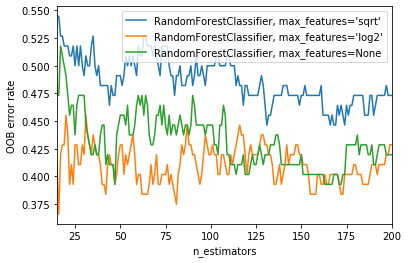

In [18]:
kegg_df = kegg_bt.to_dataframe().transpose().sort_index()
md = md.sort_index()
assert(all(kegg_df.index==md.index))

kegg_labels = np.array([1 if x=="T1D" else 0 for x in md.analysis_t1d])
# Saving feature names for later usef
kegg_feature_list = list(kegg_df.columns)
# Convert to numpy array
kegg_features = np.array(kegg_df)


rf_tuning(kegg_features, kegg_labels, 200)


In [19]:
kegg_rf = RandomForestRegressor(n_estimators = 75, random_state = 42,warm_start=True, max_features='log2',
                               oob_score=True)
# Train the model on training data
kegg_rf.fit(kegg_features, kegg_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=75, n_jobs=None, oob_score=True,
                      random_state=42, verbose=0, warm_start=True)

In [20]:
kegg_rf.oob_score_

0.02015550364579144

In [21]:
get_importances(kegg_feature_list, kegg_rf)

['Variable: K03631               Importance: 0.01',
 'Variable: K07230               Importance: 0.01',
 'Variable: K02946               Importance: 0.0',
 'Variable: K00131               Importance: 0.0',
 'Variable: K11144               Importance: 0.0',
 'Variable: K05832               Importance: 0.0',
 'Variable: K06878               Importance: 0.0',
 'Variable: K19971               Importance: 0.0',
 'Variable: K01738               Importance: 0.0',
 'Variable: K01619               Importance: 0.0',
 'Variable: K03100               Importance: 0.0',
 'Variable: K03308               Importance: 0.0',
 'Variable: K21572               Importance: 0.0',
 'Variable: K03536               Importance: 0.0',
 'Variable: K05770               Importance: 0.0',
 'Variable: K00782               Importance: 0.0',
 'Variable: K06142               Importance: 0.0',
 'Variable: K07220               Importance: 0.0',
 'Variable: K07078               Importance: 0.0',
 'Variable: K15635           

In [39]:
def make_boxplot(df, var_col, value_col, axis_label):
    grps = set(df[var_col])
    anova_values = [list(df.loc[df[var_col] == x][value_col]) for x in grps]
    print(f_oneway(*anova_values))
    #PLOT
    plot_dat = df.copy()

    plot_dat["x_axis"] = pd.Categorical(df[var_col],
                                        categories=["NH",
                                                    "OH",
                                                    "NT1D",
                                                    "OT1D"])
    p = (pn.ggplot(data = plot_dat) +
    pn.geom_boxplot( pn.aes( x="x_axis", y=value_col), outlier_alpha=0) +
     pn.geom_jitter( pn.aes(x="x_axis", y=value_col), size=1, width=.1) +
     pn.labs( x="", y=axis_label) +
     pn.theme_classic(base_size=14) +
     pn.theme(
     axis_text = pn.element_text(color="black"))
     
    )
    return(p)

F_onewayResult(statistic=0.4856108350631806, pvalue=0.6929827390617389)


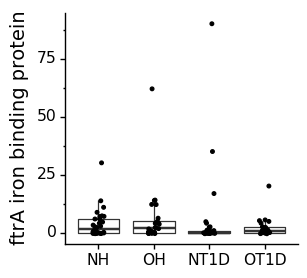

<ggplot: (-9223363257712782760)>

In [40]:
gene = "K07230"
kegg_df = pd.DataFrame(kegg_bt.to_dataframe().transpose())
kegg_df = kegg_df.loc[:,[gene]].join(md)
kegg_df[gene] = [int(x) for x in kegg_df[gene]]

pn.options.figure_size = (3,3)
make_boxplot(kegg_df, "analysis_disease_stage_group", gene, "ftrA iron binding protein")

# Uniref randomForest

In [43]:
uniref_df = bt.to_dataframe().transpose().sort_index()
md = md.sort_index()
assert(all(uniref_df.index==md.index))

uniref_labels = np.array([1 if x=="T1D" else 0 for x in md.analysis_t1d])
# Saving feature names for later usef
uniref_feature_list = list(uniref_df.columns)
# Convert to numpy array
uniref_features = np.array(uniref_df)


rf_tuning(uniref_features, uniref_labels, 200)


/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


KeyboardInterrupt: 

In [44]:
uniref_rf = RandomForestRegressor(n_estimators = 100, random_state = 42,warm_start=True, max_features='log2',
                               oob_score=True)
# Train the model on training data
uniref_rf.fit(uniref_features, uniref_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=42, verbose=0, warm_start=True)

In [45]:
uniref_rf.oob_score_

-0.03941602541749867

In [46]:
get_importances(uniref_feature_list, uniref_rf)

['Variable: A0A010NUV9           Importance: 0.0',
 'Variable: A0A010NY48           Importance: 0.0',
 'Variable: A0A010NYA8           Importance: 0.0',
 'Variable: A0A010Q7E2           Importance: 0.0',
 'Variable: A0A010Z872           Importance: 0.0',
 'Variable: A0A015PIH8           Importance: 0.0',
 'Variable: A0A015QD05           Importance: 0.0',
 'Variable: A0A015QDY2           Importance: 0.0',
 'Variable: A0A015QF54           Importance: 0.0',
 'Variable: A0A015QX35           Importance: 0.0',
 'Variable: A0A015SGT6           Importance: 0.0',
 'Variable: A0A015SXE1           Importance: 0.0',
 'Variable: A0A015TFH6           Importance: 0.0',
 'Variable: A0A015TKS2           Importance: 0.0',
 'Variable: A0A015TX87           Importance: 0.0',
 'Variable: A0A015TXS0           Importance: 0.0',
 'Variable: A0A015TXV7           Importance: 0.0',
 'Variable: A0A015TXW7           Importance: 0.0',
 'Variable: A0A015TYU7           Importance: 0.0',
 'Variable: A0A015TZF5         